# IMDB Sentiment Analysis

# Imports

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import pipeline

from collections import Counter

import torch
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.tokenize import word_tokenize

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Functions

In [5]:
def check_class_imbalance(df:pd.DataFrame, target:pd.Series, col:str):
  counter = Counter(target)
  for k,v in counter.items():
    per = v/len(target) * 100
    print("Class=%s, Count=%d, Percentage=%.3f%%" % (k,v, per))
  
  ax = df[col].value_counts().sort_index().plot(
  kind="bar", 
  title="Count of Reviews by Target", 
  figsize=(10,5)
  )
  ax.set_xlabel(col)
  plt.show()
  
def remove_stop_words(review:str):
    word_tokens = " ".join(word_tokenize(review))
    filtered_word_tokens = re.sub(r'[^a-zA-Z\s]', '', word_tokens).split(" ")
    filtered_sentence = [w.lower().strip() for w in filtered_word_tokens if not w.lower() in ENGLISH_STOP_WORDS]
    return ' '.join(filtered_sentence).strip()
def evaluate_model(X, y, model):
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
  
  metric = make_scorer(f1_score)
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

def testing_selected_models(names:list, models:list, X:pd.DataFrame, y:pd.Series):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    model_performance = []
    for i in range(len(models)):
        model = models[i]
        # Evaluate the model
        scores = evaluate_model(X, y, model)
        # summarize and store
        model_performance.append({
            "Model": names[i],
            "Mean": np.mean(scores),
            "STD":np.std(scores)
        })
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Mean", ascending=False)
def get_selected_models(names):
  """
  Returns selected models for ML processing

  Args:
      names (_type_):List

  Returns:
      List of models
  """
  models = {
    "LDA": LinearDiscriminantAnalysis(),
    "GPC": GaussianProcessClassifier(),
    "GNB": GaussianNB(),
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "MN": MultinomialNB()
  }
  
  return [models[model] for model in names]

def testing_selected_models(names:list, models:list, X:pd.DataFrame, y:pd.Series):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    model_performance = []
    for i in range(len(models)):
        model = models[i]
        scores = evaluate_model(X, y, model)
        model_performance.append({
            "Model": names[i],
            "Mean": np.mean(scores),
            "STD":np.std(scores)
        })
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Mean", ascending=False)

def test_train_test_val_splits_on_models(names, models, X, y):
    model_performance = []
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)
    
    for i in range(len(models)):
        model, model_name = models[i], names[i]
        model.fit(X_train, y_train)
        
        y_val_pred = model.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        
        y_test_pred = model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        
        model_performance.append({
            "Model": model_name,
            "Validation Accuracy": val_accuracy,
            "Test Accuracy": test_accuracy
        })
        
        conf_mat = confusion_matrix(y_test,y_test_pred)
        plt.figure(figsize=(8,6))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix {model_name}')
        plt.show()
        
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Validation Accuracy", ascending=False)

def sampling_methods(X, y):
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)
    
    return (X_res, y_res)

# EDA Analysis

In [6]:
df = pd.read_csv("/Users/maukanmir/Downloads/archive/Cleaned.csv", nrows=20000)
df

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tec...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there is a family where a little boy...,negative
4,petter mattei s love in the time of money is...,positive
...,...,...
19995,ok for starters taxi driver is amazing this...,negative
19996,it is sort of hard for me to say it because i...,negative
19997,i still liked it though warren beatty is only...,positive
19998,we could still use black adder even today ima...,positive


# Check for Nulls and Dupes

In [7]:
print(f"Null Count: {df.isna().sum()}")
print(f"Dupe Count: {df.duplicated().sum()}")

Null Count: review       0
sentiment    0
dtype: int64
Dupe Count: 74


In [8]:
df[df.duplicated()]

,review,sentiment
3537,quite what the producers of this appalling ada...,negative
3769,my favourite police series of all time turns t...,positive
4391,beautiful film pure cassavetes style gena ro...,positive
6352,if you liked the grinch movie go watch that...,negative
6479,i want very much to believe that the above quo...,negative
...,...,...
19720,the problem with so many people watching this ...,positive
19827,goodnight mister tom begins in an impossibly ...,negative
19861,this movie starts out as if it were a comedy ...,negative
19890,humm an italian movie starred by david hassel...,negative


In [9]:
df.drop_duplicates(inplace=True)

# Check For Class Imbalance

Class=positive, Count=9880, Percentage=49.583%
Class=negative, Count=10046, Percentage=50.417%


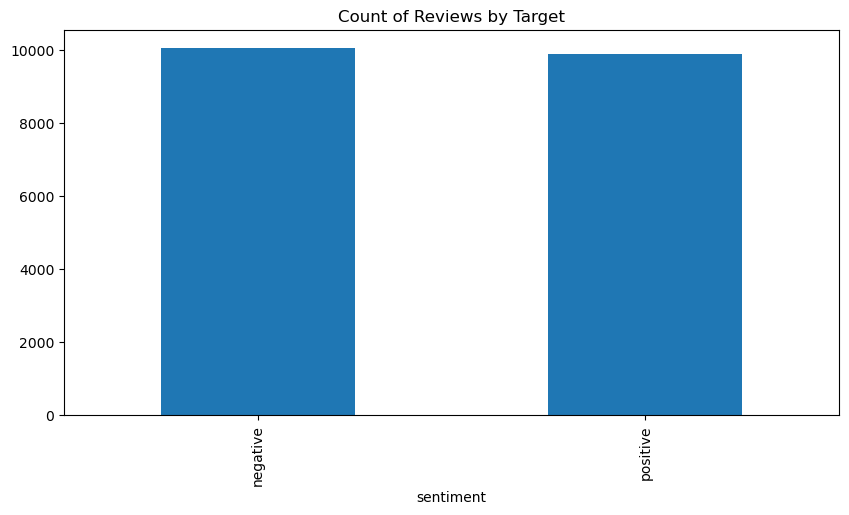

In [10]:
check_class_imbalance(df,df['sentiment'],'sentiment')

In [11]:
df['sentiment'] = df['sentiment'].apply(lambda x: 0 if x == 'negative' else 1)

In [12]:
df['len_text'] = df['review'].apply(lambda x: len(x))
df['num_words'] = df['review'].apply(lambda x: len(x.split())) 

# Visuals

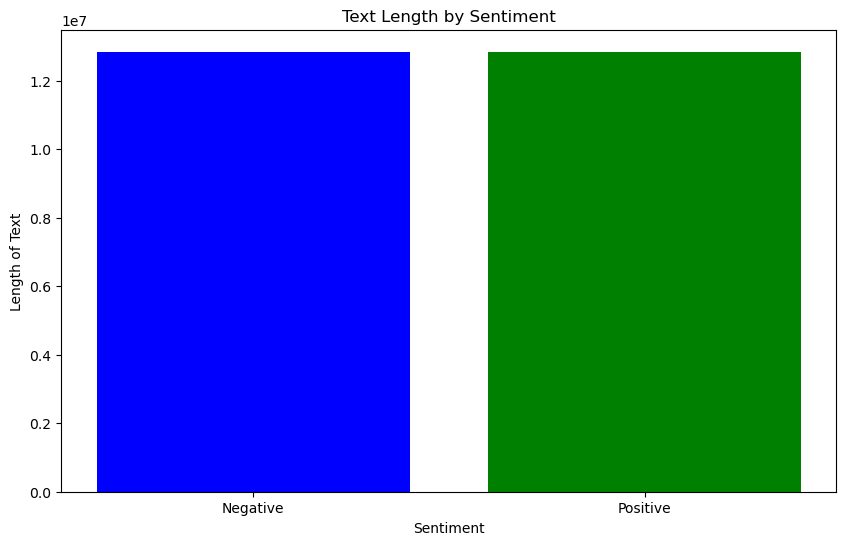

In [13]:
len_text = df.groupby('sentiment')['len_text'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(len_text['sentiment'], len_text['len_text'], color=['blue', 'green']) 
plt.xlabel('Sentiment')
plt.ylabel('Length of Text')
plt.title('Text Length by Sentiment') 
plt.xticks(ticks=len_text['sentiment'], labels=['Negative', 'Positive'])
plt.show()

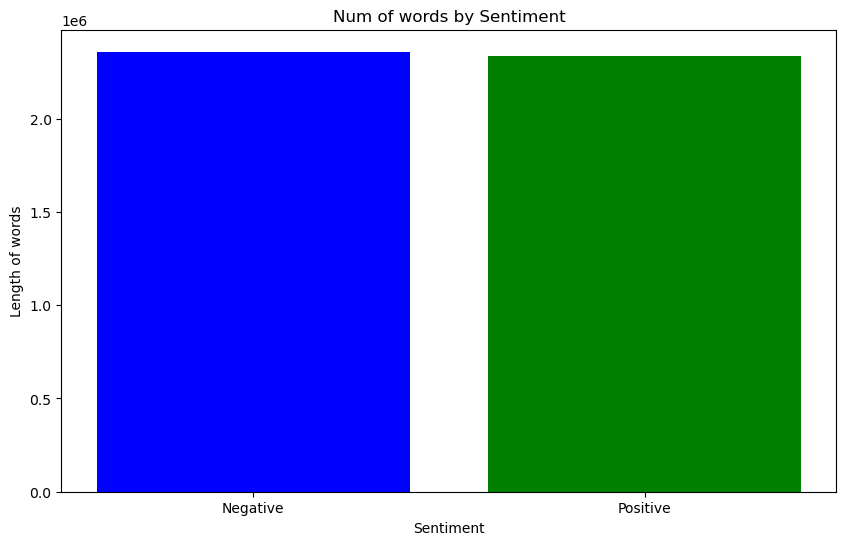

In [14]:
num_words = df.groupby('sentiment')['num_words'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(num_words['sentiment'], num_words['num_words'], color=['blue', 'green']) 
plt.xlabel('Sentiment')
plt.ylabel('Length of words')
plt.title('Num of words by Sentiment') 
plt.xticks(ticks=num_words['sentiment'], labels=['Negative', 'Positive'])
plt.show()

In [15]:
df['review'] = df['review'].apply(lambda text: remove_stop_words(text))

# Fairly even type of reviews regardless of sentiment

# Separate Features

In [16]:
X, y = df['review'], df['sentiment']

# TFIDF Method

In [17]:
vectorizer = TfidfVectorizer(max_features=200)

tfidf_matrix = vectorizer.fit_transform(X)
features = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Baseline Model Performance

In [18]:
from sklearn.dummy import DummyClassifier

model = DummyClassifier(strategy='uniform') 

scores = evaluate_model(features, y, model)
print('Mean: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean: 0.498 (0.008)


# Advanced Model Metrics

In [19]:

names = ['LR']

models = get_selected_models(names)
testing_selected_models(names, models, features, y)

,Model,Mean,STD
0,LR,0.793136,0.004688


In [20]:
names = ['SVC']

models = get_selected_models(names)
testing_selected_models(names, models, features, y)

,Model,Mean,STD
0,SVC,0.794129,0.005602


In [21]:
names = ['XGB']

models = get_selected_models(names)
testing_selected_models(names, models, features, y)

,Model,Mean,STD
0,XGB,0.776497,0.004197


In [22]:
names = ['RFC']

models = get_selected_models(names)
testing_selected_models(names, models, features, y)

,Model,Mean,STD
0,RFC,0.772833,0.00518


In [23]:
names = ['GBC']

models = get_selected_models(names)
testing_selected_models(names, models, features, y)

,Model,Mean,STD
0,GBC,0.777916,0.004052


In [24]:
names = ['LDA']

models = get_selected_models(names)
testing_selected_models(names, models, features, y)

,Model,Mean,STD
0,LDA,0.792487,0.005155


In [25]:
names = ['KNN']

models = get_selected_models(names)
testing_selected_models(names, models, features, y)

,Model,Mean,STD
0,KNN,0.674895,0.014358


In [26]:
names = ['MN']

models = get_selected_models(names)
testing_selected_models(names, models, features, y)

,Model,Mean,STD
0,MN,0.779305,0.004918


# Bert Model

In [27]:
from transformers import DistilBertTokenizer, DistilBertModel

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')
model = DistilBertModel.from_pretrained('distilbert-base-cased')

In [28]:
def get_embeddings(text:str):
    """
    - The function get_embeddings is designed to convert input text into a vector representation, 
    or embedding, using a transformer model 
    (like BERT or DistilBERT). These embeddings can be used for various 
    natural language processing tasks such as text classification, clustering, or similarity searches.
    
    - torch.no_grad(): This context manager tells PyTorch not to compute or store gradients. 
    This is important during inference when you only need to do forward propagation, 
    as it reduces memory consumption and speeds up computation.
    
    - last_hidden_state: This tensor contains the output features from the last layer of the 
    transformer for each token. 
    For models like BERT, this typically has dimensions 
    [batch_size, sequence_length, hidden_size]
    
    - This line calculates the mean of the last_hidden_state across the sequence length (tokens). 
    The mean operation reduces the tensor from [batch_size, sequence_length, hidden_size] 
    to [batch_size, hidden_size], resulting in a single vector representation for each 
    sequence in the batch. This vector captures the overall semantic meaning of the text.

    Args:
        text (str): _description_

    Returns:
        _type_: _description_
    """
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    last_hidden_states = outputs.last_hidden_state
    
    mean_embeddings = last_hidden_states.mean(dim=1)
    return mean_embeddings.numpy()

In [32]:
bert_df = df[['review','sentiment']].copy()

In [33]:
bert_df['review'] = bert_df['review'].apply(lambda review : get_embeddings(review))

In [35]:
features = np.array(bert_df['review'].tolist()).reshape(bert_df.shape[0], -1)

In [36]:

names = ['LR']

models = get_selected_models(names)
testing_selected_models(names, models, features, y)

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Model,Mean,STD
0,LR,0.836503,0.006693


In [ ]:

names = ['SVC']

models = get_selected_models(names)
testing_selected_models(names, models, features, y)

,Model,Mean,STD
0,SVC,0.850849,0.004147


In [ ]:

names = ['XGB']

models = get_selected_models(names)
testing_selected_models(names, models, features, y)

,Model,Mean,STD
0,XGB,0.838186,0.004478


In [ ]:
names = ['RFC']

models = get_selected_models(names)
testing_selected_models(names, models, features, y)

,Model,Mean,STD
0,RFC,0.818278,0.005734


In [ ]:
names = ['DTC']

models = get_selected_models(names)
testing_selected_models(names, models, features, y)

,Model,Mean,STD
0,DTC,0.699235,0.006166


In [ ]:
names = ['GBC']

models = get_selected_models(names)
testing_selected_models(names, models, features, y)

,Model,Mean,STD
0,GBC,0.832225,0.004672


In [ ]:
names = ['LDA']

models = get_selected_models(names)
testing_selected_models(names, models, features, y)

,Model,Mean,STD
0,LDA,0.863911,0.003051


In [ ]:
names = ['GNB']

models = get_selected_models(names)
testing_selected_models(names, models, features, y)

,Model,Mean,STD
0,GNB,0.767755,0.009673


In [ ]:
names = ['KNN']

models = get_selected_models(names)
testing_selected_models(names, models, features, y)

,Model,Mean,STD
0,KNN,0.756127,0.009123


# Bert Model outperforms TFIDF method on a number of models

# LSTM

In [37]:

from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense
from tensorflow.keras.models import Sequential

model = Sequential()

vocab_size = len(tokenizer.get_vocab()) + 1 
model.add(Embedding(input_dim=vocab_size, output_dim=32))
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
seq = [sequence for sequence in df['review']]
model_inputs = tokenizer(seq, padding=True, return_tensors='tf')

In [39]:
import tensorflow as tf

dataset = tf.data.Dataset.from_tensor_slices((model_inputs['input_ids'], y))

In [40]:

dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [41]:
len_dataset= len(dataset)

train = dataset.take(int(len_dataset*.7))
test = dataset.skip(int(len_dataset*.7)).take(int(len_dataset*.2))
val = dataset.skip(int(len_dataset*.9)).take(int(len_dataset*.1))

In [42]:

history = model.fit(train, epochs=5, batch_size=16, verbose=0, validation_data=val)

2024-05-03 17:44:03.995154: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


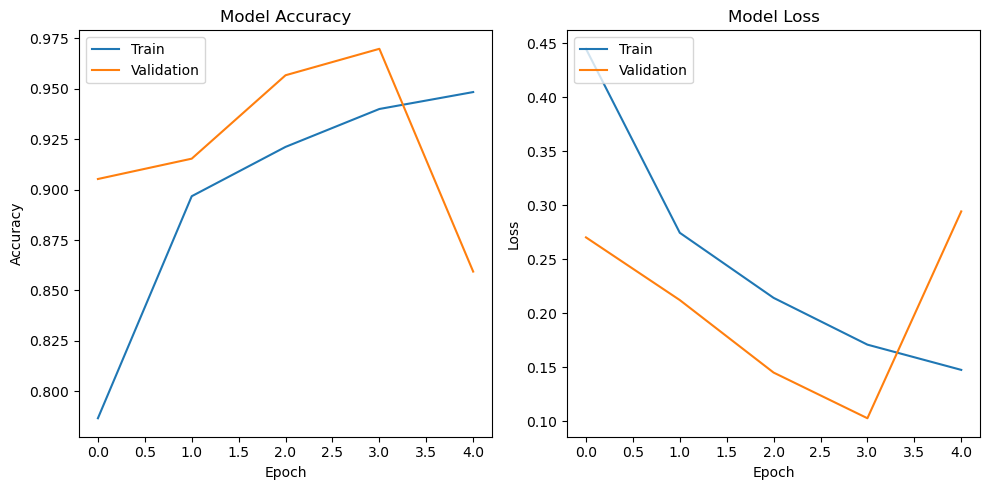

In [44]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [43]:
for i, (train_acc, val_acc) in enumerate(zip(history.history['accuracy'], history.history['val_accuracy']), start=1):
    print(f"Epoch {i}, Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")

Epoch 1, Training Accuracy: 0.7867, Validation Accuracy: 0.9052
Epoch 2, Training Accuracy: 0.8967, Validation Accuracy: 0.9153
Epoch 3, Training Accuracy: 0.9212, Validation Accuracy: 0.9567
Epoch 4, Training Accuracy: 0.9399, Validation Accuracy: 0.9698
Epoch 5, Training Accuracy: 0.9483, Validation Accuracy: 0.8594
